In [ ]:
"""
Reference:
# https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=e0Ts3OZ3MuzP
"""

### **Installing SAM**

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 974 (delta 237), reused 222 (delta 222), pack-reused 605 (from 1)
Receiving objects: 100% (974/974), 121.67 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (340/340), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.5 MB/s eta 0:00:0

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.1 MB/s eta 0:00:00


### **Generating the Masks**

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p {HOME}/checkpoints
#!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
#!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
#!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_small.pt"
CONFIG = "sam2_hiera_s.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/images_pad/Sameer_Samsung/Cow/"
files = os.listdir(path)

print(files)

['20241107_133854.jpg', '20241107_133851.jpg', '20241107_133852.jpg', '20241107_133855.jpg', '20241107_133904.jpg', '20241107_133920.jpg', '20241107_133919.jpg', '20241107_133922.jpg', '20241107_134005.jpg', '20241107_133925.jpg', '20241107_133924.jpg', '20241107_134014.jpg', '20241107_134035.jpg', '20241107_134026.jpg']


In [ ]:
len(files)

14

In [ ]:
file_name = files[0]

IMAGE_PATH = path+file_name #"/content/drive/MyDrive/Colab Notebooks/images_pad/20241107_134004.jpg" #f"{HOME}/data/dog.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)

#RESIZED_DIMENSIONS = (800, 1200)

#height, width = image_bgr.shape[:2]
#scale = min(RESIZED_DIMENSIONS[0] / width, RESIZED_DIMENSIONS[1] / height)
#new_dimensions = (int(width * scale), int(height * scale))  # Width first, then height
#image_resized_bgr = cv2.resize(image_bgr, new_dimensions)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### **Output format**

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

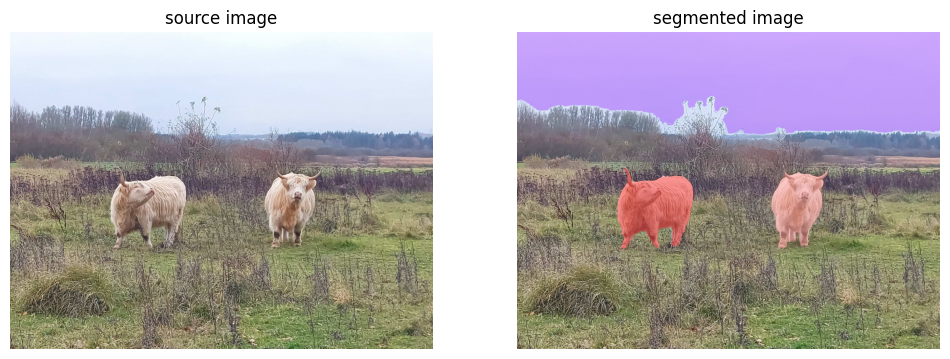

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

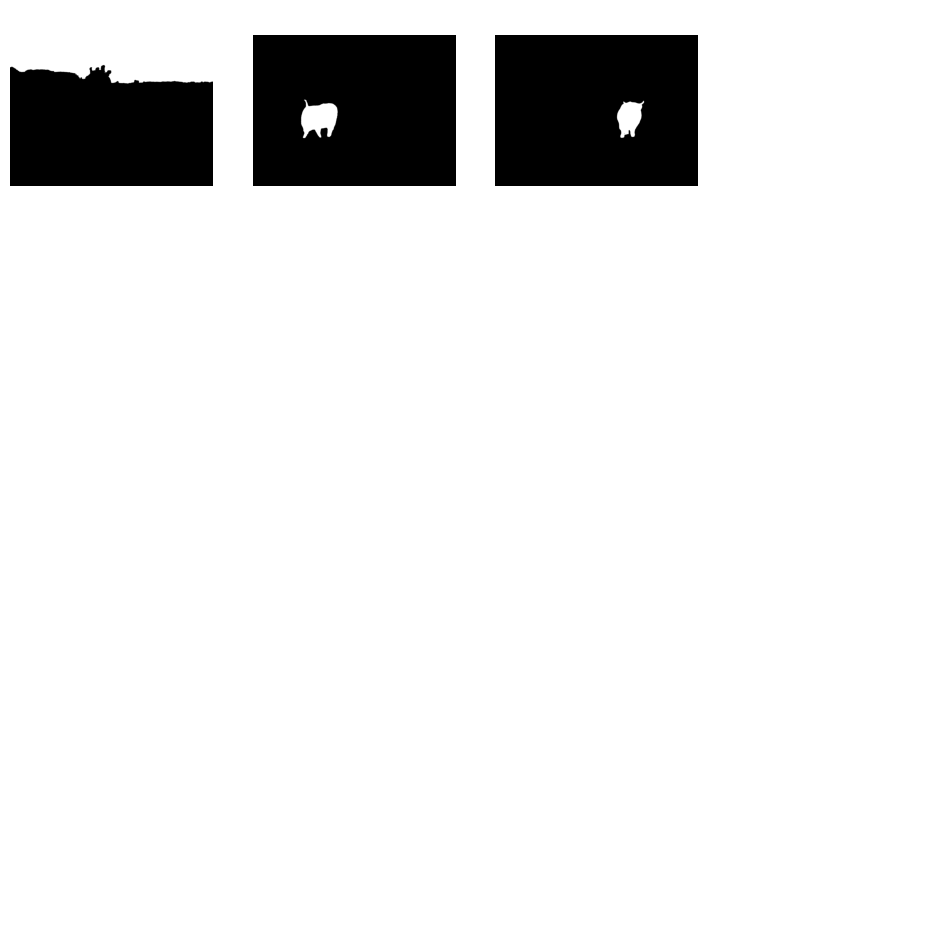

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

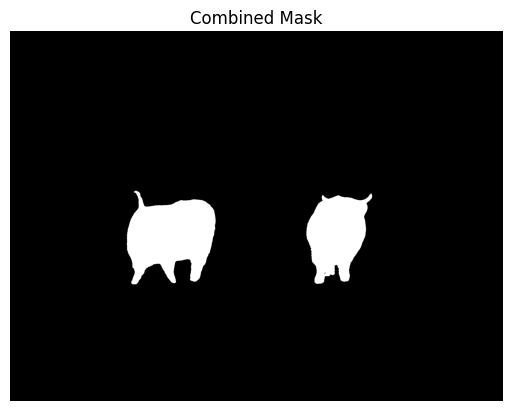

In [ ]:
combined_mask = np.sum(masks[1:3], axis=0) > 0
combined_mask = combined_mask.astype(np.uint8) * 255

plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask")
plt.axis("off")
plt.show()

In [ ]:
cv2.imwrite(f"{path}{file_name}_mask.png", combined_mask)

True